# Sentiment Analysis
## Projects Concepts
### Approaching a Project

Mengembangkan aplikasi dalam skala besar tidaklah mudah. Jangan langsung terjun dan mencoba untuk menyelesaikan semuanya sekaligus. Seperti petuah bijak berikut:

"A goal without a plan is just a wish."

Mulailah dengan rencana! Berikut beberapa langkah yang sebaiknya diikuti ketika mengembangkan aplikasi:

- buatlah outline langkah demi langkah yang dibutuhkan untuk membangun aplikasi
- kemudian tulis pseudocode
- kembangkan sintaks satu per satu

Dan sebelum submit, pastikan:

- semua bugs sudah dibasmi
- cek rubrik dan pastikan proyek kamu sudah memenuhi semua requirements

### Project Overview

DATA COLUMNS:
marketplace       - 2 letter country code of the marketplace where the review was written.
customer_id       - Random identifier that can be used to aggregate reviews written by a single author.
review_id         - The unique ID of the review.
product_id        - The unique Product ID the review pertains to. In the multilingual dataset the reviews
for the same product in different countries can be grouped by the same product_id.
product_parent    - Random identifier that can be used to aggregate reviews for the same product.
product_title     - Title of the product.
product_category  - Broad product category that can be used to group reviews
(also used to group the dataset into coherent parts).
star_rating       - The 1-5 star rating of the review.
helpful_votes     - Number of helpful votes.
total_votes       - Number of total votes the review received.
vine              - Review was written as part of the Vine program.
verified_purchase - The review is on a verified purchase.
review_headline   - The title of the review.
review_body       - The review text.
review_date       - The date the review was written.

DATA FORMAT
Tab ('\t') separated text file, without quote or escape characters.
First line in each file is header; 1 line corresponds to 1 record.

In this assignment, you have to demonstrate:

- How to load and prepare text for modeling.
- How to develop a RNN for text classification sentiment analysis with Tensorflow and improve model performance.


In [5]:
!pip install tensorflow-datasets
!pip install tensorflow
import numpy as np
import tensorflow_datasets as tfds

tfds.disable_progress_bar()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Setup
## Importing Libraries

In [6]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import csv
%matplotlib inline


In [7]:
data = pd.read_csv ('https://s3.amazonaws.com/amazon-reviews-pds/tsv/amazon_reviews_us_Apparel_v1_00.tsv.gz',
                    sep='\t',
                    error_bad_lines=False)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version.


  exec(code_obj, self.user_global_ns, self.user_ns)
b'Skipping line 49396: expected 15 fields, saw 22\nSkipping line 57008: expected 15 fields, saw 22\n'
b'Skipping line 82075: expected 15 fields, saw 22\nSkipping line 104435: expected 15 fields, saw 22\nSkipping line 109766: expected 15 fields, saw 22\nSkipping line 124024: expected 15 fields, saw 22\nSkipping line 129914: expected 15 fields, saw 22\nSkipping line 130172: expected 15 fields, saw 22\n'
b'Skipping line 161515: expected 15 fields, saw 22\n'
b'Skipping line 230464: expected 15 fields, saw 22\n'
b'Skipping line 292640: expected 15 fields, saw 22\nSkipping line 293681: expected 15 fields, saw 22\nSkipping line 316511: expected 15 fields, saw 22\nSkipping line 317239: expected 15 fields, saw 22\nSkipping line 326099: expected 15 fields, saw 22

In [8]:
data.shape

(5881874, 15)

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5881874 entries, 0 to 5881873
Data columns (total 15 columns):
 #   Column             Dtype  
---  ------             -----  
 0   marketplace        object 
 1   customer_id        int64  
 2   review_id          object 
 3   product_id         object 
 4   product_parent     int64  
 5   product_title      object 
 6   product_category   object 
 7   star_rating        float64
 8   helpful_votes      float64
 9   total_votes        float64
 10  vine               object 
 11  verified_purchase  object 
 12  review_headline    object 
 13  review_body        object 
 14  review_date        object 
dtypes: float64(3), int64(2), object(10)
memory usage: 673.1+ MB


In [10]:
numerical_columns = list(data.select_dtypes(include=['int64']).columns.values) + list(data.select_dtypes(include=['float64']).columns.values)
categorical_columns = list(data.select_dtypes(include=['object']))

# cetak variabel yang numerik
numerical_columns

['customer_id',
 'product_parent',
 'star_rating',
 'helpful_votes',
 'total_votes']

In [11]:
# cetak variabel yang kategorikal
categorical_columns

['marketplace',
 'review_id',
 'product_id',
 'product_title',
 'product_category',
 'vine',
 'verified_purchase',
 'review_headline',
 'review_body',
 'review_date']

In [12]:
data.head()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,32158956,R1KKOXHNI8MSXU,B01KL6O72Y,24485154,Easy Tool Stainless Steel Fruit Pineapple Core...,Apparel,4.0,0.0,0.0,N,Y,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",2013-01-14
1,US,2714559,R26SP2OPDK4HT7,B01ID3ZS5W,363128556,V28 Women Cowl Neck Knit Stretchable Elasticit...,Apparel,5.0,1.0,2.0,N,Y,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,2014-03-04
2,US,12608825,RWQEDYAX373I1,B01I497BGY,811958549,James Fiallo Men's 12-Pairs Low Cut Athletic S...,Apparel,5.0,0.0,0.0,N,Y,Great Socks for the money.,"Nice socks, great colors, just enough support ...",2015-07-12
3,US,25482800,R231YI7R4GPF6J,B01HDXFZK6,692205728,Belfry Gangster 100% Wool Stain-Resistant Crus...,Apparel,5.0,0.0,0.0,N,Y,Slick hat!,"I bought this for my husband and WOW, this is ...",2015-06-03
4,US,9310286,R3KO3W45DD0L1K,B01G6MBEBY,431150422,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,Apparel,5.0,0.0,0.0,N,Y,I would do it again!,Perfect dress and the customer service was awe...,2015-06-12


## Deskriptif Statistik untuk atribut numerikal

In [13]:
# deskriptif statistik untuk data latih
data[numerical_columns].describe()

,customer_id,product_parent,star_rating,helpful_votes,total_votes
count,5.881874e+06,5.881874e+06,5.881873e+06,5.881873e+06,5.881873e+06
mean,2.538800e+07,5.029080e+08,4.105261e+00,9.742111e-01,1.165795e+00
std,1.576273e+07,2.889382e+08,1.259230e+00,2.071668e+01,2.125568e+01
min,1.000300e+04,6.650000e+02,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.239497e+07,2.520753e+08,4.000000e+00,0.000000e+00,0.000000e+00
50%,2.336791e+07,5.049314e+08,5.000000e+00,0.000000e+00,0.000000e+00
75%,4.013374e+07,7.551277e+08,5.000000e+00,0.000000e+00,1.000000e+00
max,5.309656e+07,9.999979e+08,5.000000e+00,4.127800e+04,4.188900e+04


## Mengetahui jumlah data untuk masing-masing katagori

In [14]:
data.groupby('verified_purchase').count()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,review_headline,review_body,review_date
verified_purchase,,,,,,,,,,,,,,
N,591569,591569,591569,591569,591569,591568,591569,591569,591569,591569,591569,591562,591508,591556
Y,5290304,5290304,5290304,5290304,5290304,5290293,5290304,5290304,5290304,5290304,5290304,5290256,5289581,5290209


In [15]:
data.groupby('product_category').count()

,marketplace,customer_id,review_id,product_id,product_parent,product_title,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
product_category,,,,,,,,,,,,,,
2011-08-04,1,1,1,1,1,1,0,0,0,0,0,0,0,0
Apparel,5881873,5881873,5881873,5881873,5881873,5881861,5881873,5881873,5881873,5881873,5881873,5881818,5881089,5881765


# Cleansing Data

### Memastikan tidak ada missing values pada Kolom Kategorikal
--------------------------------------------
Pada keterangan dataset yang dilampirkan, missing values pada data ditandai dengan label "unknown" pada beberapa kolom dengan tipe kategorikal. Oleh karena, kolom kategorikal yang memuat label "unknown" akan diganti menjadi nan untuk menandai adanya missing values (unstandard missing values)

In [16]:
# Mencetak semua nilai unik pada masing-masing kolom kategori
for cat_col in categorical_columns:
    print("Nilai unik untuk kolom ", cat_col.upper())
    print(data[cat_col].unique())
    print('='*30)

Nilai unik untuk kolom  MARKETPLACE
['US']
Nilai unik untuk kolom  REVIEW_ID
['R1KKOXHNI8MSXU' 'R26SP2OPDK4HT7' 'RWQEDYAX373I1' ... 'R3PB8K42BMNI40'
 'R2PK1N9NG1JM4C' 'R2ORDL3TCNYNHC']
Nilai unik untuk kolom  PRODUCT_ID
['B01KL6O72Y' 'B01ID3ZS5W' 'B01I497BGY' ... '0000032050' '0000032042'
 '0000032034']
Nilai unik untuk kolom  PRODUCT_TITLE
['Easy Tool Stainless Steel Fruit Pineapple Corer Slicer Peeler Cut (One size, sliver)'
 'V28 Women Cowl Neck Knit Stretchable Elasticity Long Sleeve Slim Fit Sweater Dress'
 "James Fiallo Men's 12-Pairs Low Cut Athletic Sport Socks" ...
 'Adult Ballet Tutu Purple' 'Adult Tutu Assorted Colors (Turquoise)'
 'Adult Ballet Tutu Yellow']
Nilai unik untuk kolom  PRODUCT_CATEGORY
['Apparel' '2011-08-04']
Nilai unik untuk kolom  VINE
['N' 'Y' nan]
Nilai unik untuk kolom  VERIFIED_PURCHASE
['Y' 'N' nan]
Nilai unik untuk kolom  REVIEW_HEADLINE
['★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★'
 'Favorite for winter. Very warm!' 'Great Socks for the money.'

In [17]:
# mengganti nilai uniq pada PRODUCT_CATEGORY
data['product_category'].replace('2011-08-04','Apparel',inplace=True)


## Merangkum total missing values (nan) values

In [18]:
# missing values pada data train
print("Jumlah nan missing values atribut kategori = ",data[categorical_columns].isnull().sum().sum())
print("Jumlah nan missing values atribut numerikal = ",data[numerical_columns].isnull().sum().sum())


Jumlah nan missing values atribut kategori =  964
Jumlah nan missing values atribut numerikal =  3


## Penanganan Missing Values
Untuk data kategorikal, missing values akan diisi dengan modus dari atribut X, sedangkan untuk data numerikal missing values akan diisi dengan median dari atribut Z.

### Pisahkan data yang bertipe kategorik dan numerik

In [19]:
#categorical data
data_categorical = data[categorical_columns]

# numerical data
data_numerical = data[numerical_columns]

### Input untuk filling nan pada atribut kategorikal

In [20]:
# Machine learning process
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


# features analysis libraries
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2,mutual_info_classif
from sklearn.decomposition import PCA

## Fit data training 

In [21]:
imputer_categorical = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer_numerical = SimpleImputer(missing_values=np.nan, strategy='most_frequent')


In [22]:
#Categorical
# fit dengan data training
imputer_categorical.fit(data_categorical)

SimpleImputer(strategy='most_frequent')

In [23]:
#numerical
# fit dengan data training
imputer_numerical.fit(data_numerical)

SimpleImputer(strategy='most_frequent')

In [24]:
# transform ke data latih
data_categorical = imputer_categorical.transform(data_categorical)
data_numerical = imputer_numerical.transform(data_numerical)

# buat hasil array ke dalam dataframe
data_categorical = pd.DataFrame(data_categorical,columns=categorical_columns)
data_numerical = pd.DataFrame (data_numerical,columns=numerical_columns)

# Concate categorical columns dengan numerical columns
data = pd.concat([data_categorical,data_numerical],axis=1)

#Check kalau masih ada missing values terlewat
# missing values pada data train
print("Jumlah nan missing values atribut kategori = ",data[categorical_columns].isnull().sum().sum())
print("Jumlah nan missing values atribut numerikal = ",data[numerical_columns].isnull().sum().sum())


Jumlah nan missing values atribut kategori =  0
Jumlah nan missing values atribut numerikal =  0


In [25]:
data.head()

,marketplace,review_id,product_id,product_title,product_category,vine,verified_purchase,review_headline,review_body,review_date,customer_id,product_parent,star_rating,helpful_votes,total_votes
0,US,R1KKOXHNI8MSXU,B01KL6O72Y,Easy Tool Stainless Steel Fruit Pineapple Core...,Apparel,N,Y,★ THESE REALLY DO WORK GREAT WITH SOME TWEAKING ★,"These Really Do Work Great, But You Do Need To...",2013-01-14,32158956.0,24485154.0,4.0,0.0,0.0
1,US,R26SP2OPDK4HT7,B01ID3ZS5W,V28 Women Cowl Neck Knit Stretchable Elasticit...,Apparel,N,Y,Favorite for winter. Very warm!,I love this dress. Absolute favorite for winte...,2014-03-04,2714559.0,363128556.0,5.0,1.0,2.0
2,US,RWQEDYAX373I1,B01I497BGY,James Fiallo Men's 12-Pairs Low Cut Athletic S...,Apparel,N,Y,Great Socks for the money.,"Nice socks, great colors, just enough support ...",2015-07-12,12608825.0,811958549.0,5.0,0.0,0.0
3,US,R231YI7R4GPF6J,B01HDXFZK6,Belfry Gangster 100% Wool Stain-Resistant Crus...,Apparel,N,Y,Slick hat!,"I bought this for my husband and WOW, this is ...",2015-06-03,25482800.0,692205728.0,5.0,0.0,0.0
4,US,R3KO3W45DD0L1K,B01G6MBEBY,JAEDEN Women's Beaded Spaghetti Straps Sexy Lo...,Apparel,N,Y,I would do it again!,Perfect dress and the customer service was awe...,2015-06-12,9310286.0,431150422.0,5.0,0.0,0.0


## Eksplorasi Data (Visualisasi
### Berapa persentase setiap nilai pada kepuasan pembelian?

In [26]:
data['verified_purchase'].value_counts()

Y    5290305
N     591569
Name: verified_purchase, dtype: int64

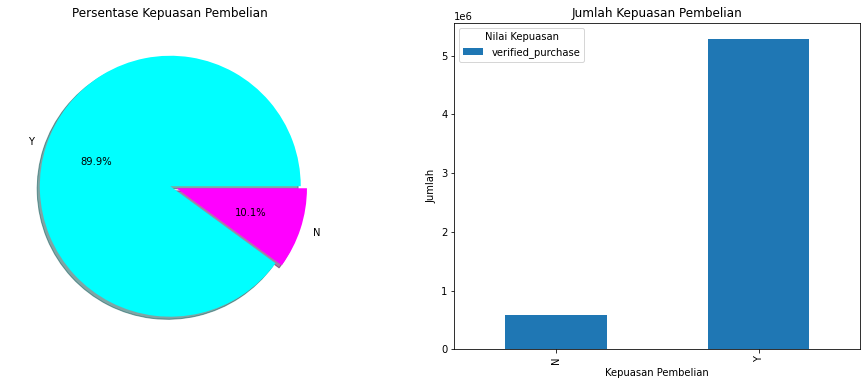

In [27]:
fig, ax = plt.subplots(1,2,figsize=(16,6))

# persentase "berlangganan deposito"
data['verified_purchase'].value_counts().plot(
    kind='pie',
    autopct='%.1f%%',
    explode=[0,0.05], 
    cmap='cool',
    shadow=True,
    ax=ax[0]
)
ax[0].set_title('Persentase Kepuasan Pembelian')
ax[0].set_ylabel('')

# Barchart besaran setiap nilai pada kelas target
data.groupby('verified_purchase').agg({'verified_purchase':'count'}).plot(
    kind='bar',
    ax=ax[1]
)
ax[1].set_title('Jumlah Kepuasan Pembelian')
ax[1].set_ylabel('Jumlah')
ax[1].set_xlabel('Kepuasan Pembelian')
ax[1].legend(title='Nilai Kepuasan')

## Setup 

Import matplotlib and create a helper function to plot graphs:

In [28]:
tfds.disable_progress_bar()
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation,TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer

#### Menghilangkan kolom yang tidak diperlukan

In [30]:
rating = ['low','neutral','high']

def rating_y(y):
    if y<=2:
        return rating[0]
    elif y>=4:
        return rating[2]
    else:
        return rating[1]


data['rating_cat'] = data['star_rating'].apply(rating_y)

In [31]:
data_fix=data.drop(['marketplace', 'review_id',
                      'product_id','product_parent',
                      'product_category','helpful_votes',
                       'total_votes','vine',
                       'verified_purchase','review_headline',
                     'review_date','customer_id',
                      'product_title',], axis=1)

In [32]:
data_fix=data_fix.head(10000)
data_fix.head()

,review_body,star_rating,rating_cat
0,"These Really Do Work Great, But You Do Need To...",4.0,high
1,I love this dress. Absolute favorite for winte...,5.0,high
2,"Nice socks, great colors, just enough support ...",5.0,high
3,"I bought this for my husband and WOW, this is ...",5.0,high
4,Perfect dress and the customer service was awe...,5.0,high


In [33]:
stemmer = SnowballStemmer("english")
tokenizer = RegexpTokenizer("[a-z']+")

def tokenize(text):
    tokens = tokenizer.tokenize(text)
    return [stemmer.stem(t) for t in tokens] 

def get_tf(data_fix, use_idf, max_df=1.0, min_df=1, ngram_range=(1,1)):
    if use_idf:
        m = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    else:
        m = CountVectorizer(max_df=max_df, min_df=min_df, stop_words='english', ngram_range=ngram_range, tokenizer=tokenize)
    
    d = m.fit_transform(data_fix.values.astype('U'))
    
    return m, d
tf_m, tf_d = get_tf(data_fix['review_body'], use_idf=False, max_df=0.90, min_df=10)
tfidf_m, tfidf_d = get_tf(data_fix['review_body'], use_idf=True, max_df=0.90, min_df=10)


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:401: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'forti', 'henc', 'hereaft', 'herebi', 'howev', 'hundr', 'inde', 'mani', 'meanwhil', 'moreov', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'togeth', 'twelv', 'twenti', 'veri', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  % sorted(inconsistent)


In [34]:
n_topics = 10

def get_lda(data_fix, topics):
    m = LatentDirichletAllocation(n_components=topics, n_jobs=-1, learning_method='online').fit(data_fix)
    d = m.transform(data_fix)
    return m, d

def get_kmeans(data_fix, k, scale=True):
    if scale:
        s = MinMaxScaler()
        data = s.fit_transform(data_fix)
    
    m = KMeans(n_clusters=k).fit(data_fix)
    d = m.predict(data_fix)
    return m, d        

lda_m, lda_d = get_lda(tf_d, n_topics)
kmean_m, kmean_d = get_kmeans(tfidf_d, n_topics, scale=False)

In [35]:
def show_topics(model, feature_names, n_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic #%d:" % topic_idx)
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-n_words - 1:-1]]))
    print()

In [36]:
def show_cluster_topics(cluster_labels, tf_matrix, feature_names, n_words):
    d = pd.DataFrame(tf_matrix.toarray())
    d['c'] = cluster_labels
    d = d.groupby('c').sum().T
    
    for col in d:
        top_n = d[col].nlargest(n_words).index.tolist()
        print("Cluster #%d:" % col)
        print(", ".join([feature_names[i]
                for i in top_n]))
    print()

In [37]:
print("Top 15 stemmed words per topic in LDA model\n")
show_topics(lda_m, tf_m.get_feature_names(), 15)

Top 15 stemmed words per topic in LDA model

Topic #0:
year, cheap, old, disappoint, look, design, cover, head, like, item, babi, cost, month, poor, amaz
Topic #1:
like, pictur, look, skirt, sock, daughter, money, buy, just, pair, compani, realli, feet, jacket, noth
Topic #2:
br, review, receiv, veri, product, honest, exchang, discount, materi, color, wear, comfort, soft, unbias, feel
Topic #3:
size, fit, small, order, larg, i'm, like, wear, medium, littl, veri, ', just, expect, big
Topic #4:
wear, just, look, suit, like, got, purchas, say, time, becaus, order, i'm, want, tri, happi
Topic #5:
dress, waist, beauti, belt, wear, bust, onli, just, pretti, littl, tight, hip, becaus, fabric, veri
Topic #6:
shape, costum, area, print, bodi, short, wore, dress, style, wed, scrub, romper, night, tall, purpl
Topic #7:
wallet, pocket, card, hat, bra, use, hold, strap, work, leather, bag, like, need, great, nice
Topic #8:
love, great, fit, veri, qualiti, perfect, good, nice, look, price, color, co

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [38]:
def get_svd(data_fix, components):
    svd = TruncatedSVD(n_components=components).fit(data_fix)
    o = pd.DataFrame(svd.transform(data_fix), columns=range(0,components))
    return svd,o

def get_tsne(data_fix, components, perplexity):
    tsne = TSNE(n_components=components, perplexity=perplexity, n_iter=1000)
    o = pd.DataFrame(tsne.fit_transform(data_fix), columns=range(0,components))
    return tsne,o

svd_v, svd_m = get_svd(tfidf_d, 50)
tnse_v, tsne_m = get_tsne(svd_m, 2, 25)

lda_c = lda_d.argmax(axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


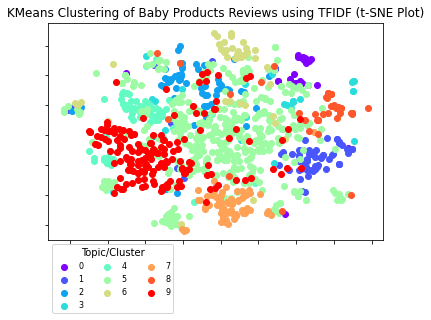

In [39]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib

def plot_scatter_2d(x, y, c, sample_size, title):
    df = pd.DataFrame({'x': x, 'y': y, 'c': c}).sample(sample_size)
    l = len(np.unique(c))
    
    ax = plt.subplot(111)
    colors = cm.rainbow(np.linspace(0, 1, l))
                                   
    for c in range(0,l):
        qq = df[df['c']==c]
        ax.scatter(qq['x'], qq['y'],c=colors[c], label=c)
    plt.legend(loc='upper left', numpoints=1, ncol=3, fontsize=8, bbox_to_anchor=(0, 0), title='Topic/Cluster')
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    ax.set_title(title)
    plt.show()

get_ipython().run_line_magic('matplotlib', 'inline')
plot_scatter_2d(tsne_m[0], tsne_m[1], kmean_d, 1000, 'KMeans Clustering of Baby Products Reviews using TFIDF (t-SNE Plot)')


In [40]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_d,
                                                    data_fix['rating_cat'],test_size=0.3)

In [41]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
def calculate_cv(X, y):
    results = {
        'lr': [],
        'svm': [],
        'nb': [],
        'combined': []
    }
    lm = LogisticRegression()
    svm = LinearSVC()
    nb = MultinomialNB()
    vc = VotingClassifier([('lm', lm), ('svm', svm), ('nb', nb)])
    
    for c in rating:
        y_adj = np.array(y==c)
        results['lr'].append((cross_val_score(lm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['svm'].append((cross_val_score(svm, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['nb'].append((cross_val_score(nb, X, y_adj, cv=10, scoring='accuracy').mean(), c))
        results['combined'].append((cross_val_score(vc, X, y_adj, cv=10, scoring='accuracy').mean(), c))
    return results

cv_scores = calculate_cv(X_test, y_test)

print("Model accuracy predictions\n")
for m,s in cv_scores.items():
    for ss in s:
        print("{M} model ({R} rating): {S:.1%}".format(M=m.upper(), R=ss[1], S=ss[0]))
    print()


Model accuracy predictions

LR model (low rating): 87.6%
LR model (neutral rating): 91.1%
LR model (high rating): 85.6%

SVM model (low rating): 88.4%
SVM model (neutral rating): 90.0%
SVM model (high rating): 86.4%

NB model (low rating): 85.7%
NB model (neutral rating): 91.3%
NB model (high rating): 81.2%

COMBINED model (low rating): 87.7%
COMBINED model (neutral rating): 91.1%
COMBINED model (high rating): 85.6%



In [42]:
def get_lr(x, y):
    models = []
    for c in rating:
        y_adj = np.array(y==c)
        lm = LogisticRegression()
        lm_f = lm.fit(x, y_adj)
        models.append(lm_f)
    return models

lr_m = get_lr(X_train, y_train)

In [43]:
get_ipython().run_line_magic('matplotlib', 'inline')

def plot_coef(title, model, feature_names, n_words):
    v = []
    for topic_idx, topic in enumerate(model.coef_):
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[:-n_words - 1:-1]]
        [v.append([feature_names[i], model.coef_.item(i)]) for i in topic.argsort()[0:n_words]]
    df = pd.DataFrame(v, columns=['Term','Coefficient']).sort_values(by='Coefficient',ascending=False)
    df['c'] = df['Coefficient']>0
    ax = df.plot(x='Term', y='Coefficient', kind='barh', color=df['c'].map({True: 'g', False: 'r'}), grid=True, legend=False,
           title=title)
    ax.set_xlabel("Coefficient")

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


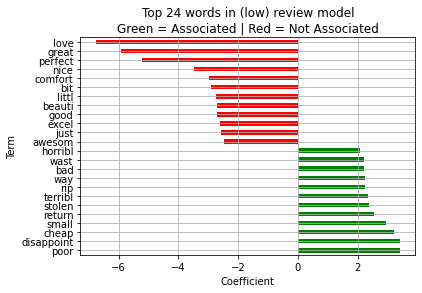

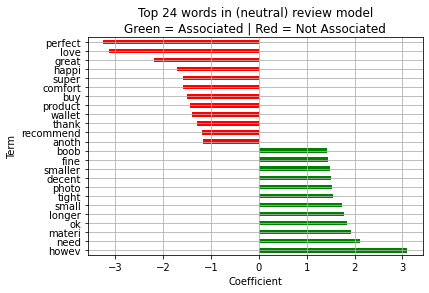

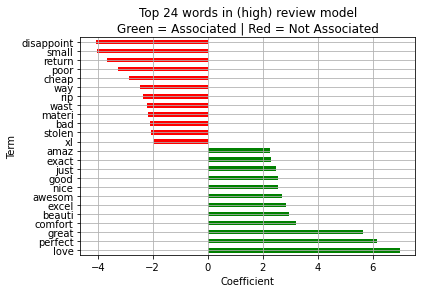

In [44]:
n_terms = 12
for c in range(0,len(rating)):
    plot_coef('Top {N} words in ({R}) review model\nGreen = Associated | Red = Not Associated'.format(N=n_terms*2, R=rating[c]), 
              lr_m[c], tfidf_m.get_feature_names(), n_terms)

In [45]:
def test_review(text):
    test_str = [text]
    test_new = tfidf_m.transform(test_str)

    print('Review text: "{R}"\n'.format(R=test_str[0]))
    print('Model Prediction')
    for m in range(0,3):
        print('Model ({M}): {P:.1%}'.format(M=rating[m], P=lr_m[m].predict_proba(test_new)[0][1]))

## Coba Review Text Kepuasan Pembeli

In [48]:
test_review('I bought an apparel is reject and I returned it when it arrived.')

Review text: "I bought an apparel is reject and I returned it when it arrived."

Model Prediction
Model (low): 50.4%
Model (neutral): 10.0%
Model (high): 29.1%


In [49]:
test_review('I really like an apparel, good looking, and the price was cheap I am glad to bought it')

Review text: "I really like an apparel, good looking, and the price was cheap I am glad to bought it"

Model Prediction
Model (low): 16.5%
Model (neutral): 5.8%
Model (high): 69.1%
